<a href="https://colab.research.google.com/github/Himanshu069/3D-AI/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

#mnist dataset
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

#train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17642251.08it/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 499022.41it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2983097.70it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9573130.03it/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



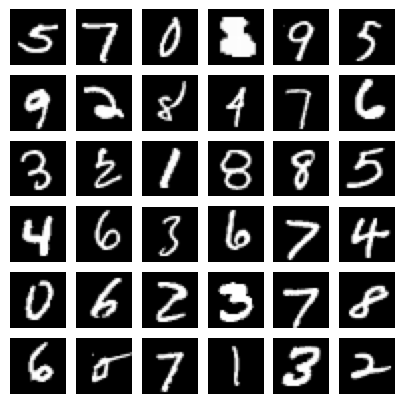

In [ ]:
#36 images for visualizing
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 36
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5,5))
grid = ImageGrid(fig, 111, nrows_ncols=(6,6), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim =400, latent_dim=200):
      super(VAE, self).__init__()

      self.encoder = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.LeakyReLU(0.2),
          nn.Linear(hidden_dim, latent_dim),
          nn.LeakyReLU(0.2)
      )
      #latent mean and variance
      self.mean_layer = nn.Linear(latent_dim, 2)
      self.logvar_layer = nn.Linear(latent_dim, 2)

      self.decoder = nn.Sequential(
          nn.Linear(2, latent_dim),
          nn.LeakyReLU(0.2),
          nn.Linear(latent_dim, hidden_dim),
          nn.LeakyReLU(0.2),
          nn.Linear(hidden_dim, input_dim),
          nn.Sigmoid()
          )

    def encode(self,x):
      x = self.encoder(x)
      mean, logvar = self.mean_layer(x), self.logvar_layer(x)
      return mean, logvar

    def reparameterize(self, mean, log_var):
      epsilon = torch.randn_like(log_var)
      z = mean + log_var*epsilon
      return z

    def decode(self,x):
      return self.decoder(x)

    def forward(self,x):
      mean, logvar = self.encode(x)
      z = self.reparameterize(mean, logvar)
      x_hat = self.decode(z)
      return x_hat, mean, logvar

In [ ]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def loss_function(x, x_hat, mean, log_var):
  reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var  - mean.pow(2) - log_var.exp())

  return reconstruction_loss + KLD


In [ ]:
#training model
def train(model, optimizer, epochs, x_dim=784):
  model.train()
  for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
      x = x.view(batch_size, x_dim)
      optimizer.zero_grad()
      x_hat, mean, log_var = model(x)
      loss = loss_function(x, x_hat,mean,log_var)

      overall_loss += loss.item()
      loss.backward()
      optimizer.step()

    print("\tEpoch", epoch + 1,"\tAverage Loss: ",overall_loss/(batch_idx*batch_size))
  return overall_loss

train(model, optimizer , epochs=50)

	Epoch 1 	Average Loss:  177.74225840267633
	Epoch 2 	Average Loss:  157.33750792336184
	Epoch 3 	Average Loss:  153.2390157097767
	Epoch 4 	Average Loss:  151.02335053865818
	Epoch 5 	Average Loss:  149.22836369535162
	Epoch 6 	Average Loss:  147.41126323820953
	Epoch 7 	Average Loss:  145.74589304113627
	Epoch 8 	Average Loss:  144.63597675813855
	Epoch 9 	Average Loss:  143.6349203098915
	Epoch 10 	Average Loss:  142.88595994952524
	Epoch 11 	Average Loss:  142.16695263590358
	Epoch 12 	Average Loss:  141.56982474045284
	Epoch 13 	Average Loss:  140.90539690173728
	Epoch 14 	Average Loss:  140.47991400054778
	Epoch 15 	Average Loss:  140.19101319582117
	Epoch 16 	Average Loss:  139.65197922644512
	Epoch 17 	Average Loss:  139.2163725349541
	Epoch 18 	Average Loss:  139.18135411232262
	Epoch 19 	Average Loss:  138.57305279306658
	Epoch 20 	Average Loss:  138.63532099397432
	Epoch 21 	Average Loss:  138.1671199557857
	Epoch 22 	Average Loss:  137.90179786949602
	Epoch 23 	Average Loss

8001692.544921875

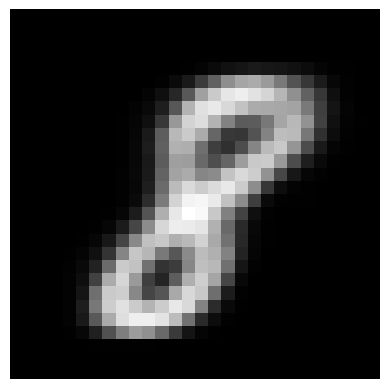

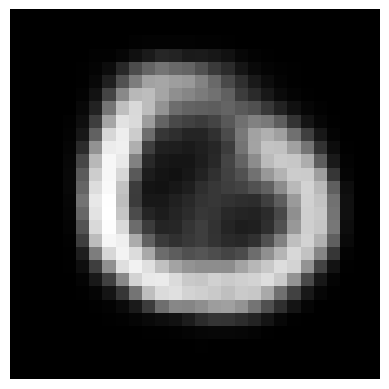

(None, None)

In [ ]:
def generate_digit(mean, var):
  z_sample = torch.tensor([[mean,var]],dtype=torch.float)
  x_decoded = model.decode(z_sample)
  digit = x_decoded.detach().cpu().reshape(28,28)
  plt.imshow(digit, cmap='gray')
  plt.axis('off')
  plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [ ]:
'''def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)'''